# Orbital Mechanics for a Solar Sail

This notebook was created for the simulation of a solar sail in various orbital systems.



## Imports

There are various libraries that must be imported for the simulation of coupled ODEs

In [143]:
from scipy.integrate import odeint
import numpy as np
import math
import matplotlib.pyplot as pyplt
import matplotlib as plt

## Universal Constants

There are some universal constants which remain the same no matter the system and we define them here at a top level for future use.

In [144]:
G_CONSTANT = 6.6743e-11
C_CONSTANT = 299792458
L0_CONSTANT = 3.828e26
SOLAR_MASS_CONSTANT = 1.989e30

## Sail Parameters

For our sail, we consider common design trends and come up with parameters based on these for three different designs. The first being a small 'concept' sail, a larger sail for interplanetary travel and an even larger sail for interstellar travel. 
* In terms of reflectivity, most sails use an aluminium layer of thickness 20 nm or more. This achieves a reflectivity of between 0.88 and 0.9. Thus we base our parameter for the concept and interplanetary designs on the average of these two. I.e. 0.89. For the interstellar vehicle, we assume some progress in technology and thus aim for a reflectivity of 0.95.
* For area and mass. We consider their ratio. The IKAROS mission had a mass of 315 kg, an area of 14x14 metres and thus a ratio of 196:315 so we use this for the concept sail. For interstellar designs a ratio of 12960:1 is cited by Robert L. Forward. Thus, for the interplanetary sail we take a value imbetween these of 1000:1.


In [145]:
concept_sail_reflectivity = 0.89
planetary_sail_reflectivity = 0.89
stellar_sail_reflectivity = 0.95

concept_sail_area_to_mass = 0.622
planetary_sail_area_to_mass = 1000
stellar_sail_reflectivity = 12960

## 2 Bodies: Sun and Sail

For this our two equations are as follows:

$$\ddot r = r \dot \theta^2 + \frac{G M}{r^2} + \frac{\left(1 + R \cos(2 \phi) \right) L_0 A}{4 c m \pi r^2} \cos(\phi)$$

$$\ddot \theta = - \frac{2 \dot r \dot \theta}{r} - \frac{R \sin(2 \phi) L_0 A}{4 c \pi m r^3} \cos(\phi)$$

However, we group parameters in such a way by setting:

$$\tau = t_c t, \text{ where: } t_c = 31536000 \\$$
$$\tilde{r} = r_c r, \text{ where: } r_c = 1.495978707 \cdot 10^{11}$$ 

So as to produce:

$$\tilde{r}^2 \frac{d^2 \tilde{r}}{d \tau^2} = \tilde{r}^3 \left(\frac{d \theta}{d \tau}\right)^2 + \alpha \sigma \left(1 + R \cos(2 \phi) \right) \cos(\phi) + \beta $$
$$\tilde{r}^3 \frac{d^2 \theta}{d \tau^2} = - 2 \tilde{r}^2 \frac{d \tilde{r}}{d \tau} \frac{d \theta}{d \tau} - \alpha \sigma R \sin(2 \phi) \cos(\phi)$$

Where:

$$\alpha = \frac{t_c^2}{r_c^3} \frac{L_0}{4 c \pi}$$
$$\beta = \frac{t_c^2}{r_c^3} GM$$
$$\sigma = \frac{A}{m}$$

In [146]:
alpha = (31536000**2)/((1.495978707e11)**3) * L0_CONSTANT / (4 * C_CONSTANT * math.pi)
beta = (31536000**2)/((1.495978707e11)**3) * G_CONSTANT * SOLAR_MASS_CONSTANT

In [166]:
"""
We let:
    r'(t) = u
    u'(t) = r
    
    theta'(t) = omega(t)
    omega'(t) = -2 u omgea / r - .../r^2 cos(..)
"""

def sunAndSailODEs(x,t,R,area_to_mass,phi):
    r = x[0]
    u = x[1]
    theta = x[2]
    omega = x[3]
      
    dudt = r * omega**2 + alpha * area_to_mass * (1 + R * math.cos(2 * phi)) * math.cos(phi) / r**2 + beta/r**2
    domegadt = (-2/r) * u * omega - alpha * area_to_mass * R * math.sin(2 * phi) * math.cos(phi) / r**3
    
    return [u, dudt, omega, domegadt]

def limitingODE(x,t):
    r = x[0]
    u = x[1]
    theta = x[2]
    omega = x[3]
      
    dudt = r * omega**2
    domegadt = (-2/r) * u * omega
    
    return [u, dudt, omega, domegadt]

### Initial Conditions and Arguments

We have our concept solar sail initially going around the sun at Earth's orbital radius with an initial velocity equivalent to that of the planet. 

In [226]:
r0, rdot0, theta0, thetadot0 = 1, 0, 0, 2*math.pi
x0 = [r0,rdot0,theta0,thetadot0]

args_for_concept = (concept_sail_reflectivity,concept_sail_area_to_mass,math.pi/4)

### Solving ODEs

To solve the ODEs we use a function called odeint from the scipy library

In [227]:
t = np.linspace(0, 1,500)

x = odeint(sunAndSailODEs, x0,t, args=args_for_limiting_case)
r, rdot, theta, thetadot = x[:,0], x[:,1], x[:,2], x[:,3]

### Plotting Solution

We convert back to cartesian to plot the results.

In [228]:
def polarToCartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return(x, y)

(x,y) = polarToCartesian(r,theta)

### Plotting Orbital Radius as a Function of Time

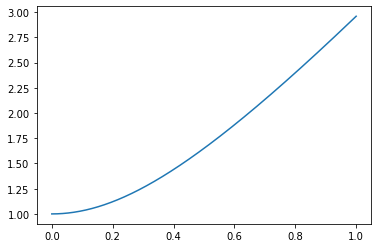

In [229]:
fig = pyplt.plot(t,r)
pyplt.show()

### Plotting Orbit of Sail

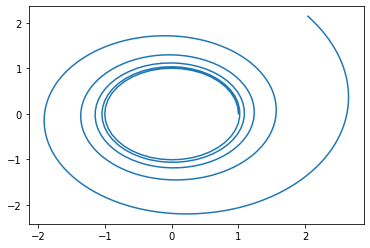

In [230]:
fig = pyplt.plot(x,y)
pyplt.show()

## 5 Bodies: Sun, Earth, Mars, Jupiter and Sail

### Generating Function for ODEs

Below we wish to create a function which can produce arbitrarily many additional planets and add them to 

In [ ]:
def generateODEs(param_dict):
    """
    This function takes n bodies in addition to the sun and sail and produces an array of ODEs for simulation.
    """
    
    